# Computer Vision Assignment 1 Part 2
---

Semester: **Fall 2022**

Due date: **September 29th 2022, 11.59PM EST.**

## Introduction
---
This assignment requires you to participate in a Kaggle competition with the rest of the class on the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb). The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2022/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file `gtsrb_kaggle.csv` that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
---
You should make a copy of this Colab (`File->Save a copy in Drive`). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is NOT ALLOWED! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.

Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

## Important Details
---
• You are only allowed 8 submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 95% 

• **Extra important:** Please use your NYU NetID as your team name on Kaggle, so the TAs can figure out which user you are on the leaderboard. 

# Dataset Preparation
___

1.  Download `dataset.zip` from the course website to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders: `training`, `validation`, and `testing`. 
3.  Go to Google Drive (on your NYU account) and make a new directory (say `cv_kaggle_assignment`).
4.  Upload each of the three subfolders to it. 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


**I am using my own computer to train so I will not use Colab and Google Drive**

In [ ]:
# Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/drive')
# %cd  /content/drive/'My Drive'/cv_kaggle_assignment/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cv_kaggle_assignment


# Dataloader

In [30]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

batch_size = 128

class MyDataset(Dataset):
    def __init__(self, X_path, y_path, transform=None):
        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
        self.transform = transform
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="data/dataset/train/X.pt", y_path="data/dataset/train/y.pt")
val_dataset = MyDataset(X_path="data/dataset/validation/X.pt", y_path="data/dataset/validation/y.pt")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),

            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 3),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 2048, 1),
            nn.ReLU(),
            nn.BatchNorm2d(2048),
            nn.AdaptiveMaxPool2d(1),

            nn.Flatten(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.3),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 43)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        # x = x.view(-1, 8192)
        # x = self.fc(x)
        return x

In [11]:
# model = MyModel()
# model
# x = torch.randn(2, 3, 32, 32)
# model(x)

# Training

In [35]:
from tqdm import tqdm

lr = 0.001
epochs = 60

model = MyModel()
model.to('cuda')
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, 30, 0.1)

def train(e):
    epoch_loss = 0
    model.train()
    for i, (data, target) in enumerate(tqdm(train_loader, desc='Training Epoch {}'.format(e))):
        data, target = data.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader.dataset)

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to('cuda'), target.to('cuda')
            output = model(data)
            validation_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    return validation_loss / len(val_loader.dataset), correct / len(val_loader.dataset)

train_losses = []
val_losses = []
accus = []
best_accu = 0
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    val_loss, accu = validation()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accus.append(accu)
    print('Train Loss {:.8f}\tValidation Loss {:.8f}\tAccuracy {:.4f}'.format(train_loss, val_loss, accu))
    if accu > best_accu:
        best_accu = accu
        model_file = 'models/model_best.pt'
        torch.save(model.state_dict(), model_file)
    scheduler.step()
torch.save(model.state_dict(), 'models/model_last.pt')

Training Epoch 1: 100%|██████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 47.40it/s]


Train Loss 0.00293823	Validation Loss 0.00130257	Accuracy 0.9579


Training Epoch 2: 100%|██████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.84it/s]


Train Loss 0.00013377	Validation Loss 0.00131835	Accuracy 0.9486


Training Epoch 3: 100%|██████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 50.00it/s]


Train Loss 0.00003323	Validation Loss 0.00092021	Accuracy 0.9651


Training Epoch 4: 100%|██████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.96it/s]


Train Loss 0.00014168	Validation Loss 0.00091493	Accuracy 0.9672


Training Epoch 5: 100%|██████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.54it/s]


Train Loss 0.00008433	Validation Loss 0.00119574	Accuracy 0.9517


Training Epoch 6: 100%|██████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.45it/s]


Train Loss 0.00002672	Validation Loss 0.00065685	Accuracy 0.9775


Training Epoch 7: 100%|██████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.25it/s]


Train Loss 0.00004983	Validation Loss 0.00077408	Accuracy 0.9755


Training Epoch 8: 100%|██████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.62it/s]


Train Loss 0.00015906	Validation Loss 0.00301203	Accuracy 0.9036


Training Epoch 9: 100%|██████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.35it/s]


Train Loss 0.00010079	Validation Loss 0.00112757	Accuracy 0.9646


Training Epoch 10: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.40it/s]


Train Loss 0.00004209	Validation Loss 0.00132454	Accuracy 0.9504


Training Epoch 11: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.48it/s]


Train Loss 0.00010168	Validation Loss 0.00083171	Accuracy 0.9716


Training Epoch 12: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.86it/s]


Train Loss 0.00003540	Validation Loss 0.00074798	Accuracy 0.9736


Training Epoch 13: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.13it/s]


Train Loss 0.00008470	Validation Loss 0.00090108	Accuracy 0.9698


Training Epoch 14: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.38it/s]


Train Loss 0.00005524	Validation Loss 0.00066384	Accuracy 0.9747


Training Epoch 15: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.00it/s]


Train Loss 0.00002165	Validation Loss 0.00360111	Accuracy 0.8822


Training Epoch 16: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.78it/s]


Train Loss 0.00013807	Validation Loss 0.00061389	Accuracy 0.9793


Training Epoch 17: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.96it/s]


Train Loss 0.00002826	Validation Loss 0.00066815	Accuracy 0.9775


Training Epoch 18: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.65it/s]


Train Loss 0.00007401	Validation Loss 0.00071861	Accuracy 0.9770


Training Epoch 19: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.13it/s]


Train Loss 0.00010228	Validation Loss 0.00071001	Accuracy 0.9703


Training Epoch 20: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.26it/s]


Train Loss 0.00005302	Validation Loss 0.00146728	Accuracy 0.9468


Training Epoch 21: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.17it/s]


Train Loss 0.00006015	Validation Loss 0.00114908	Accuracy 0.9612


Training Epoch 22: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.05it/s]


Train Loss 0.00006605	Validation Loss 0.00076291	Accuracy 0.9752


Training Epoch 23: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.11it/s]


Train Loss 0.00009765	Validation Loss 0.00070905	Accuracy 0.9680


Training Epoch 24: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.03it/s]


Train Loss 0.00002633	Validation Loss 0.00096569	Accuracy 0.9690


Training Epoch 25: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.16it/s]


Train Loss 0.00001528	Validation Loss 0.00044448	Accuracy 0.9832


Training Epoch 26: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.24it/s]


Train Loss 0.00000512	Validation Loss 0.00038170	Accuracy 0.9866


Training Epoch 27: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.01it/s]


Train Loss 0.00000608	Validation Loss 0.00044259	Accuracy 0.9853


Training Epoch 28: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.99it/s]


Train Loss 0.00000829	Validation Loss 0.00054402	Accuracy 0.9832


Training Epoch 29: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.01it/s]


Train Loss 0.00025052	Validation Loss 0.00072079	Accuracy 0.9744


Training Epoch 30: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.98it/s]


Train Loss 0.00002234	Validation Loss 0.00044936	Accuracy 0.9840


Training Epoch 31: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.12it/s]


Train Loss 0.00000681	Validation Loss 0.00041422	Accuracy 0.9860


Training Epoch 32: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.36it/s]


Train Loss 0.00000515	Validation Loss 0.00036881	Accuracy 0.9866


Training Epoch 33: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.15it/s]


Train Loss 0.00000461	Validation Loss 0.00039803	Accuracy 0.9855


Training Epoch 34: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.40it/s]


Train Loss 0.00000424	Validation Loss 0.00034928	Accuracy 0.9889


Training Epoch 35: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.65it/s]


Train Loss 0.00000455	Validation Loss 0.00042312	Accuracy 0.9853


Training Epoch 36: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.72it/s]


Train Loss 0.00000561	Validation Loss 0.00036689	Accuracy 0.9879


Training Epoch 37: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.75it/s]


Train Loss 0.00000593	Validation Loss 0.00037081	Accuracy 0.9881


Training Epoch 38: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.05it/s]


Train Loss 0.00000505	Validation Loss 0.00038659	Accuracy 0.9876


Training Epoch 39: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.95it/s]


Train Loss 0.00000494	Validation Loss 0.00039027	Accuracy 0.9871


Training Epoch 40: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.03it/s]


Train Loss 0.00000577	Validation Loss 0.00037108	Accuracy 0.9873


Training Epoch 41: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.03it/s]


Train Loss 0.00000594	Validation Loss 0.00044176	Accuracy 0.9832


Training Epoch 42: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.09it/s]


Train Loss 0.00000619	Validation Loss 0.00040820	Accuracy 0.9873


Training Epoch 43: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.97it/s]


Train Loss 0.00000656	Validation Loss 0.00041417	Accuracy 0.9868


Training Epoch 44: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.10it/s]


Train Loss 0.00000645	Validation Loss 0.00042589	Accuracy 0.9860


Training Epoch 45: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.56it/s]


Train Loss 0.00000683	Validation Loss 0.00039738	Accuracy 0.9876


Training Epoch 46: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.63it/s]


Train Loss 0.00000748	Validation Loss 0.00044651	Accuracy 0.9881


Training Epoch 47: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.67it/s]


Train Loss 0.00001071	Validation Loss 0.00044123	Accuracy 0.9858


Training Epoch 48: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.42it/s]


Train Loss 0.00000688	Validation Loss 0.00046094	Accuracy 0.9863


Training Epoch 49: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.55it/s]


Train Loss 0.00000678	Validation Loss 0.00042996	Accuracy 0.9871


Training Epoch 50: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.11it/s]


Train Loss 0.00000695	Validation Loss 0.00044419	Accuracy 0.9866


Training Epoch 51: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.68it/s]


Train Loss 0.00000690	Validation Loss 0.00042365	Accuracy 0.9863


Training Epoch 52: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.95it/s]


Train Loss 0.00000708	Validation Loss 0.00036455	Accuracy 0.9886


Training Epoch 53: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.99it/s]


Train Loss 0.00000882	Validation Loss 0.00050921	Accuracy 0.9832


Training Epoch 54: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.15it/s]


Train Loss 0.00001251	Validation Loss 0.00045901	Accuracy 0.9850


Training Epoch 55: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.96it/s]


Train Loss 0.00001293	Validation Loss 0.00045923	Accuracy 0.9832


Training Epoch 56: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.10it/s]


Train Loss 0.00000805	Validation Loss 0.00041635	Accuracy 0.9860


Training Epoch 57: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.95it/s]


Train Loss 0.00000624	Validation Loss 0.00038702	Accuracy 0.9873


Training Epoch 58: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 48.96it/s]


Train Loss 0.00000681	Validation Loss 0.00036311	Accuracy 0.9876


Training Epoch 59: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.18it/s]


Train Loss 0.00000708	Validation Loss 0.00037700	Accuracy 0.9876


Training Epoch 60: 100%|█████████████████████████████████████████████████████████████| 277/277 [00:05<00:00, 49.05it/s]


Train Loss 0.00000739	Validation Loss 0.00037911	Accuracy 0.9879


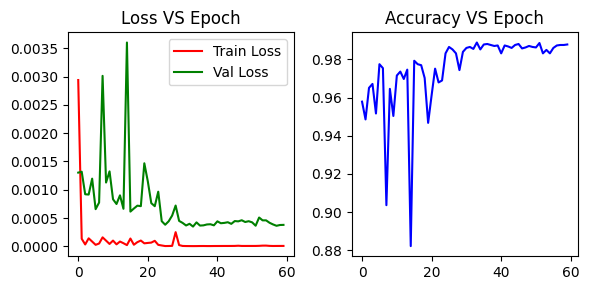

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_losses, 'r', label='Train Loss')
ax1.plot(val_losses, 'g', label='Val Loss')
ax1.legend()
ax1.set_title('Loss VS Epoch')
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(accus, 'b', label='Accuracy')
ax2.set_title('Accuracy VS Epoch')
fig.tight_layout()

# Evaluate and Submit to Kaggle



In [38]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

# output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('data/dataset/testing/test.pt')
file_ids = pickle.load(open('data/dataset/testing/file_ids.pkl', 'rb'))
model = MyModel()
state = torch.load('models/model_last.pt')
model.load_state_dict(state)
model.to('cuda')
model.eval() # Don't forget to put your model on eval mode !

for i, data in enumerate(tqdm(test_data)):
    data = data.unsqueeze(0).to('cuda')

    output = model(data)
    pred = output.data.max(1, keepdim=True)[1].cpu().item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

100%|███████████████████████████████████████████████████████████████████████████| 12630/12630 [00:24<00:00, 512.77it/s]

Written to csv file gtsrb_kaggle.csv


# Submitting to Kaggle

Now download the CSV file `grtsrb_kaggle.csv` from your Google drive and then submit it to Kaggle to check the performance of your model.

# Brief Report

I tried to use resnet series including resnet18 to resnet101 but they didn't perform well, and I guess some of them may have overfitted because the training loss droped to a extremely low magnitude but the validation loss remained at a high level. Some of them possibly were not very suitable for this task. Then I did refer to some notebooks which introduced their models. I actually did a combination of some notebooks and I used my familiar model architecture.

I used convolution layers without padding and used pooling to downsample after some convolution layers. Then I use the widely-used batch-norm technique after activation functions, which I did some research on where to put the batch-norm layer. The convolution layer with kernal size equals 1 is what I learned from a notebook. I never used this technique and I tried to add this and found it was a little better than directly using `Flatten`, so I left it there. The last part is the fully connected layers, where I added dropout layers. Though some may say that it's unnecessary to use dropout when there exists batch-norm. I tried, and it was slightly better with a dropout to prevent overfit from my several tests. The hidden number of features is through several tests and actually it didn't really matter if it's between 256 to 2048.

When training, I used `Adam` as the optimizer because of its speed. I tried to use `SGD` but it was really slow to converge and I can accept a little trade-off of accuracy. I added `weight_decay` to prevent overfit and set the learning rate at a low start point and used the learning rate scheduler to drop the magnitude of the learning rate after 30 epochs. I tried several times with different starting learning rates and different schedulers and so far this is the best. I also saved best models during training and the "best" model actually didn't perform as well as the "last" model in the test set on the public leaderboard.